<a href="https://colab.research.google.com/github/FLCarvalho/TechChallenge_fase2_indice_bovespa/blob/main/Tech_challenge_fase2_Fabio_Carvalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Bibliotecas e importações

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings("ignore")

# Formatação global
pd.options.display.float_format = '{:,.2f}'.format  # Pandas: sempre 2 casas decimais
np.set_printoptions(precision=2, suppress=True)     # Numpy: sempre 2 casas decimais, sem notação científica

# 1. Importação da base de dados

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/FLCarvalho/TechChallenge_fase2_indice_bovespa/refs/heads/main/Dados_Historicos_Ibovespa_2010_2025.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3922 entries, 0 to 3921
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      3922 non-null   object 
 1   Último    3922 non-null   float64
 2   Abertura  3922 non-null   float64
 3   Máxima    3922 non-null   float64
 4   Mínima    3922 non-null   float64
 5   Vol.      3921 non-null   object 
 6   Var%      3922 non-null   object 
dtypes: float64(4), object(3)
memory usage: 214.6+ KB


In [ ]:
print(f"linhas: {df.shape[0]:,}\ncolunas: {df.shape[1]}")

linhas: 3,922
colunas: 7


In [ ]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,23.10.2025,145.72,144.88,146.36,144.88,"6,60M","0,59%"
1,22.10.2025,144.87,144.09,145.05,144.04,"7,02B","0,55%"
2,21.10.2025,144.09,144.51,144.79,143.83,"6,19B","-0,29%"
3,20.10.2025,144.51,143.40,145.22,143.40,"6,79B","0,77%"
4,17.10.2025,143.40,142.20,143.42,141.25,"8,88B","0,84%"


**INFORMAÇÃO DA BASE DE DADOS ORIGINAL:**

0. Data - data de registro da cotação do IBOVESPA.
1. Último - valor de fechamento do índice no dia.
2. Abertura - valor do índice no início do pregão.
3. Máxima - maior valor atingido pelo índice durante o dia.
4. Mínima - menor valor atingido pelo índice durante o dia.
5. Vol. - volume negociado no dia (quantidade total de ativos transacionados).
6. Var% - variação percentual do fechamento em relação ao dia anterior.

## 1.1 - Remoção de colunas

Serão consideradas apenas as colunas “Data” e “Último” da base original, pois o objetivo é prever o valor de fechamento do dia seguinte. As demais colunas serão removidas para simplificar e reduzir a base de dados.

In [ ]:
df = df[['Data', 'Último']].dropna()

## 1.2 Validação do formatado data e transformação em indice

In [ ]:
df['Data'] = pd.to_datetime(df['Data'])

In [ ]:
df = df.set_index('Data')

In [ ]:
df = df.sort_index()
if df.index.is_monotonic_increasing:
    print("Os dados estão em ordem cronológica.")
else:
    print("Os dados não estão em ordem cronológica.")

Os dados estão em ordem cronológica.


## 1.3 Remomeação de coluna

Remomeação da coluna Último para remover o assento e evitar erros

In [ ]:
if 'Último' in df.columns and 'Close' not in df.columns:
    df = df.rename(columns={'Último':'Close'})

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3922 entries, 2010-01-04 to 2025-10-23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3922 non-null   float64
dtypes: float64(1)
memory usage: 61.3 KB


## 1.4 Visualização da base original

### 1.4.1 Visualização da serie historica

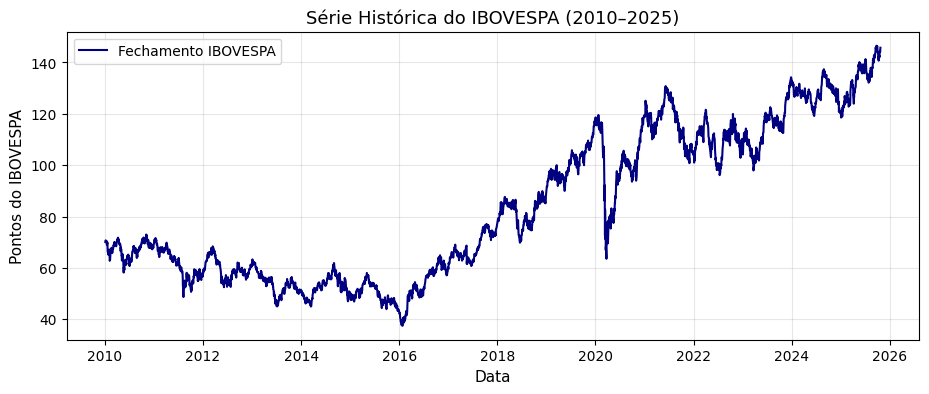

In [ ]:
plt.figure(figsize=(11,4))
plt.plot(df['Close'], label='Fechamento IBOVESPA', color='navy')
plt.title('Série Histórica do IBOVESPA (2010–2025)', fontsize=13)
plt.xlabel('Data', fontsize=11)
plt.ylabel('Pontos do IBOVESPA', fontsize=11)
plt.legend(loc='upper left', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

### 1.4.2 Decomposização sazonal da serie

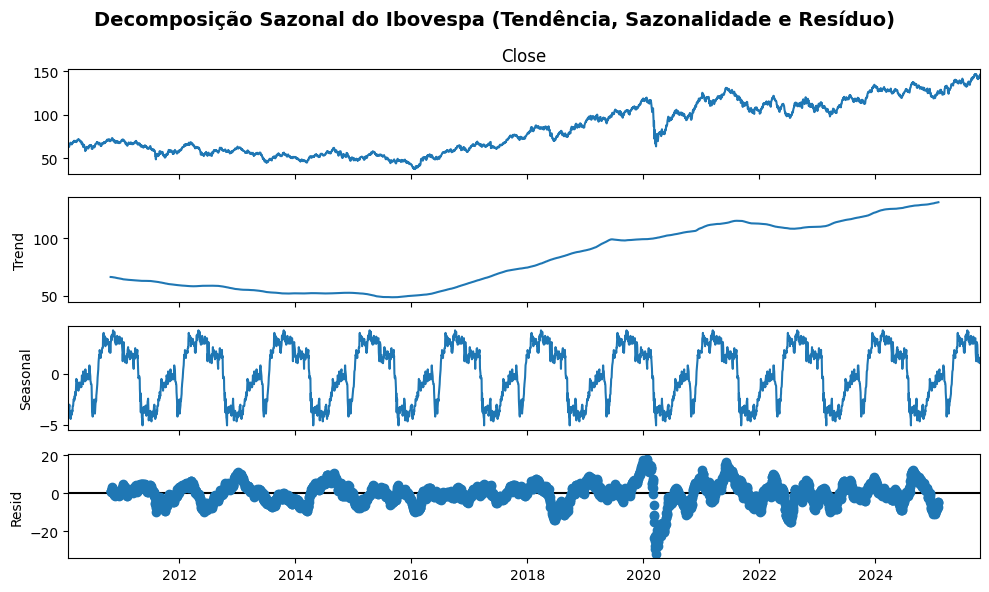

In [247]:
result = seasonal_decompose(df["Close"], model="additive", period=365)
fig = result.plot()
fig.set_size_inches(10, 6)

plt.suptitle("Decomposição Sazonal do Ibovespa (Tendência, Sazonalidade e Resíduo)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**INTERPETRAÇÃO:**

* Trend: revela o movimento de longo prazo, indicando períodos de alta e queda sustentados do índice.

* Seasonal: exibe flutuações cíclicas curtas, típicas de variações semanais ou mensais do mercado.

* Resid: representa ruídos e variações aleatórias não explicadas pelos padrões anteriores.

# 2. Teste de estacionaridade e ACF/PACF

O testes serão realizado nessa etapa para entendimento da serie e antecipação para a modelagem dos modelos ARIMA e ARIMAX

## 2.1 Teste Augmented Dickey-Fuller ADF

In [ ]:
result = adfuller(df['Close'])
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")

if result[1] > 0.05:
    print("A série NÃO é estacionária.")
    df['Close_diff'] = df['Close'].diff().dropna()
else:
    print("A série é estacionária.")

ADF Statistic: -0.4682
p-value: 0.8981
A série NÃO é estacionária.


### 2.1.1 Aplicando a primeira diferencial

In [ ]:
df['Close_diff'] = df['Close'].diff()
df=df.dropna()

### 2.1.2 Teste de estacionaridade com a serie diferenciada

In [ ]:
result = adfuller(df['Close_diff'])
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")

if result[1] > 0.05:
    print("A série NÃO é estacionária.")
    df['Close_diff'] = df['Close'].diff().dropna()
else:
    print("A série é estacionária.")

ADF Statistic: -20.6947
p-value: 0.0000
A série é estacionária.


### 2.1.3 Visualização da serie estacionária

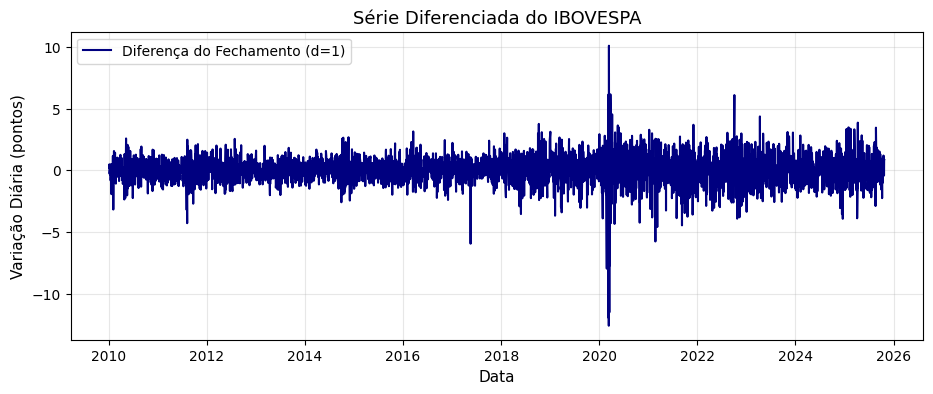

In [ ]:
plt.figure(figsize=(11,4))
plt.plot(df['Close_diff'], label='Diferença do Fechamento (d=1)', color='navy')
plt.title('Série Diferenciada do IBOVESPA', fontsize=13)
plt.xlabel('Data', fontsize=11)
plt.ylabel('Variação Diária (pontos)', fontsize=11)
plt.legend(loc='upper left', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

## 2.2 Teste ACF/PACF

ACF cruza o limite em lag 2 → q sugerido = 2
PACF cruza o limite em lag 2 → p sugerido = 2


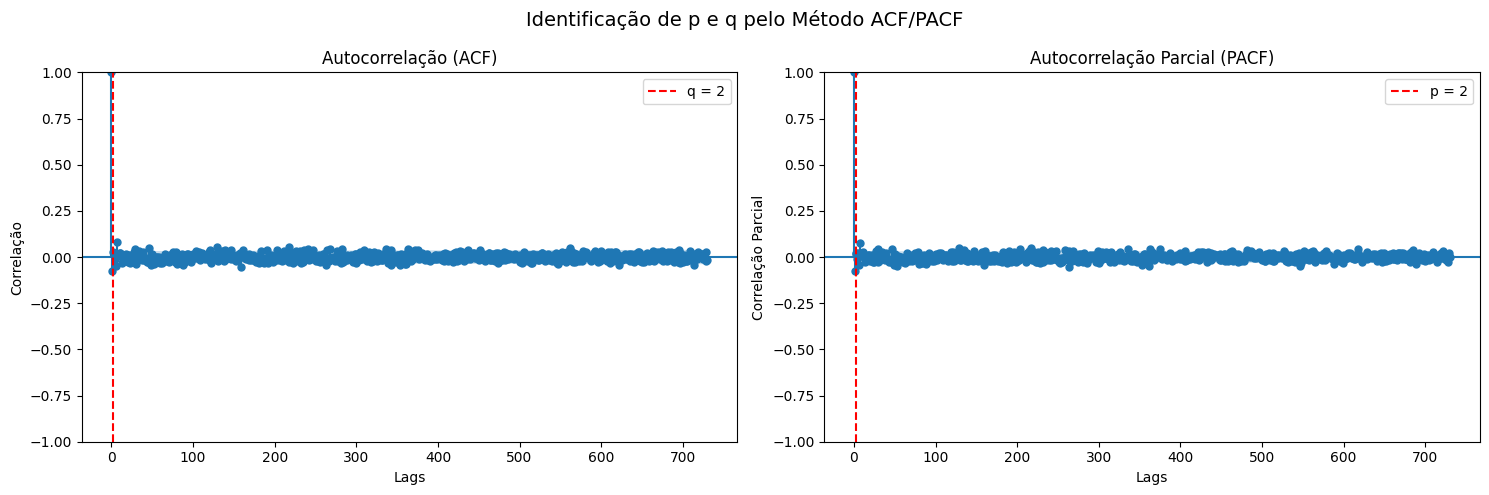

In [ ]:
  def analisar_acf_pacf(serie, lags=730):

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    #ACF
    sm.graphics.tsa.plot_acf(serie, lags=lags, ax=ax[0], alpha=0.05)
    ax[0].set_title("Autocorrelação (ACF)")
    ax[0].set_xlabel("Lags")
    ax[0].set_ylabel("Correlação")

    # Valores e limites ACF
    acf_vals, ci_acf = sm.tsa.acf(serie, nlags=lags, alpha=0.05)
    intercept_acf = np.where(abs(acf_vals) < (ci_acf[:, 1] - acf_vals))[0]
    if intercept_acf.size > 0:
        q = intercept_acf[0]
        print(f"ACF cruza o limite em lag {q} → q sugerido = {q}")
        ax[0].axvline(q, color='red', linestyle='--', label=f'q = {q}')
        ax[0].legend()
    else:
        print("ACF não cruza o limite de significância.")

    # PACF
    sm.graphics.tsa.plot_pacf(serie, lags=lags, ax=ax[1], alpha=0.05)
    ax[1].set_title("Autocorrelação Parcial (PACF)")
    ax[1].set_xlabel("Lags")
    ax[1].set_ylabel("Correlação Parcial")

    # Valores e limites PACF
    pacf_vals, ci_pacf = sm.tsa.pacf(serie, nlags=lags, alpha=0.05)
    intercept_pacf = np.where(abs(pacf_vals) < (ci_pacf[:, 1] - pacf_vals))[0]
    if intercept_pacf.size > 0:
        p = intercept_pacf[0]
        print(f"PACF cruza o limite em lag {p} → p sugerido = {p}")
        ax[1].axvline(p, color='red', linestyle='--', label=f'p = {p}')
        ax[1].legend()
    else:
        print("PACF não cruza o limite de significância.")

    fig.suptitle("Identificação de p e q pelo Método ACF/PACF", fontsize=14)
    fig.tight_layout()
    plt.show()

# Executar
analisar_acf_pacf(df['Close_diff'], lags=730)

### 2.2.2 Parametros para utilização no ARIMA

In [ ]:
p, d, q = 2, 1, 2

# 3. Criação da variavel Target

A variável target indica o movimento diário do IBOVESPA, sendo 1 quando o fechamento do dia é maior que o do dia anterior (alta) e 0 quando é menor ou igual (queda).

## 3.1 Criando a variável

In [ ]:
df['target'] = (df['Close'] > df['Close'].shift(1)).astype(int)
df = df.dropna(subset=['target'])

## 3.2 Verificando a distribuição da variável Target

In [ ]:
print(df['target'].value_counts(normalize=True).round(3))

target
1   0.51
0   0.49
Name: proportion, dtype: float64


In [246]:
target_dist = df['target'].value_counts(normalize=True).round(3) * 100
target_table = pd.DataFrame({
    'Direção': ['Alta (1)', 'Baixa (0)'],
    'Proporção (%)': target_dist.values
})

# Exibir a tabela formatada
print(target_table.to_string(index=False))

  Direção  Proporção (%)
 Alta (1)          51.10
Baixa (0)          48.90


# 4. Engenharia de Atributos (Feature Enginnering)

## 4.1 Lags

Utilizados em modelos de machine learing supervisionados aplicados a séries temporais, pois esses modelos não consideram a sequência temporal por conta própria

In [ ]:
for i in range(1, 10):
    df[f'lag_{i}'] = df['Close'].shift(i)

## 4.2 Variação Diária (%)

Representa a variação percentual do fechamento em relação ao dia anterior, indicando a intensidade e direção das mudanças diárias no índice.

In [ ]:
df['variacao_diaria'] = df['Close'].pct_change().shift(1)

## 4.3 Variação Logarítmica Diária

Mede a variação percentual entre fechamentos consecutivos em escala logarítmica, suavizando oscilações e destacando mudanças relativas de preço.


In [ ]:
df['variacao_log_diaria'] = np.log(df['Close']).diff().shift(1)

## 4.4 Médias Móveis

Capturam a tendência de curto e médio prazo do preço de fechamento, enquanto mm_diff mostra o cruzamento entre essas médias, indicando possíveis sinais de alta ou baixa.

Utilizando 5 e 20 dias, que são respectivamente o perido de uma semana e aproximadamente um mês dos pregões.

In [ ]:
df['mm_5d'] = df['Close'].rolling(window=5).mean().shift(1)
df['mm_20d'] = df['Close'].rolling(window=20).mean().shift(1)
df['mm_diff'] = df['mm_5d'] - df['mm_20d']

## 4.5 Volatilidade

Mede a variação dos preços em janelas curtas e longas; vol_diff indica se a volatilidade recente está aumentando ou diminuindo em relação ao padrão médio.

Utilizando 5 e 20 dias, que são respectivamente o perido de uma semana e aproximadamente um mês dos pregões.

In [ ]:
df['vol_5d'] = df['Close'].rolling(window=5).std().shift(1)
df['vol_20d'] = df['Close'].rolling(window=20).std().shift(1)
df['vol_diff'] = df['vol_5d'] - df['vol_20d']

# 4.6 Índice de Força Relativa

Indicador técnico criado por J. Welles Wilder em 1978, que mede a intensidade dos movimentos de alta e baixa recentes em uma escala de 0 a 100; valores elevados indicam sobrecompra e valores baixos, sobrevenda, sinalizando possíveis reversões de tendência.

In [ ]:
window = 14

delta = df['Close'].diff()

gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

# Criar séries com o mesmo índice do DataFrame
gain_series = pd.Series(gain, index=df.index)
loss_series = pd.Series(loss, index=df.index)

avg_gain = gain_series.rolling(window=window, min_periods=window).mean().shift(1)
avg_loss = loss_series.rolling(window=window, min_periods=window).mean().shift(1)

rs = avg_gain / avg_loss
df['rsi_14'] = 100 - (100 / (1 + rs))

## 4.7 Momentum

Mede a diferença entre a variação diária e a média das últimas variações, indicando a força e a velocidade do movimento recente do preço. Nessa variavel serão considerados 5 dias.

In [ ]:
df['momentum_5d'] = df['variacao_diaria'] - df['variacao_diaria'].rolling(window=5).mean().shift(1)

# 4.8 Indicador de Reversão

Identifica mudanças de direção no movimento diário dos preços, marcando 1 quando ocorre inversão de sinal na variação e 0 quando a tendência se mantém.

In [ ]:
df['reversao'] = np.sign(df['variacao_diaria']) != np.sign(df['variacao_diaria'].shift(1))
df['reversao'] = df['reversao'].astype(int)

## 4.9 Calendário

Sinalização dos dias da semana, mês e se o periodo é fim de de mês.

In [ ]:
df['dia_semana'] = df.index.dayofweek
df['mes'] = df.index.month
df['fim_mes'] = df.index.is_month_end.astype(int)

# 4.10 Limpeza dos NaN

Limpeza dos NaN geardos durante o cálculo das variáveis.

In [ ]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3901 entries, 2010-02-03 to 2025-10-23
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Close                3901 non-null   float64
 1   Close_diff           3901 non-null   float64
 2   target               3901 non-null   int64  
 3   lag_1                3901 non-null   float64
 4   lag_2                3901 non-null   float64
 5   lag_3                3901 non-null   float64
 6   lag_4                3901 non-null   float64
 7   lag_5                3901 non-null   float64
 8   lag_6                3901 non-null   float64
 9   lag_7                3901 non-null   float64
 10  lag_8                3901 non-null   float64
 11  lag_9                3901 non-null   float64
 12  variacao_diaria      3901 non-null   float64
 13  variacao_log_diaria  3901 non-null   float64
 14  mm_5d                3901 non-null   float64
 15  mm_20d              

# 5. Modelagem

## 5.1 Modelos de Classificação

### 5.1.1 Features utilizadas e Separação de base treino e teste

Preparação para os modelos KNN e Random Forest.


#### 5.1.1.1 Features

In [ ]:
features = [
    'variacao_diaria', 'variacao_log_diaria',
    'mm_5d', 'mm_20d', 'mm_diff',
    'vol_5d', 'vol_20d', 'vol_diff',
    'rsi_14', 'momentum_5d', 'reversao',
    'dia_semana', 'mes', 'fim_mes',
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
    'lag_6', 'lag_7', 'lag_8', 'lag_9'
]

#### 5.1.1.2 Separação entre variáveis X e Y

In [ ]:
X = df[features].copy()
y = df['target'].copy()

#### 5.1.1.3 Divisão treino/teste

Considerando o treino como os ultimos 30 dias

In [236]:
test_size = 30
X_train = X.iloc[:-test_size].copy()
X_test  = X.iloc[-test_size:].copy()
y_train = y.iloc[:-test_size].copy()
y_test  = y.iloc[-test_size:].copy()

# Verificação do tamanho da base e datas
print(f"Tamanho treino: {len(X_train)} linhas")
print(f"Tamanho teste:  {len(X_test)} linhas")
print(f"Treino: de {X_train.index.min().date()} até {X_train.index.max().date()}")
print(f"Teste:  de {X_test.index.min().date()} até {X_test.index.max().date()}")

Tamanho treino: 3871 linhas
Tamanho teste:  30 linhas
Treino: de 2010-02-03 até 2025-09-11
Teste:  de 2025-09-12 até 2025-10-23


#### 5.1.1.4 Normalização das variáveis

StandardScaler aplicado para padronizar as variáveis transformando todas as features para média 0 e desvio padrão 1.

In [237]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### **5.1.2 K-NEAREST NEIGHBORS (KNN)**

KNN (K-Nearest Neighbors) é um classificador supervisionado baseado na proximidade entre observações. Ele compara cada ponto de teste com seus vizinhos mais próximos no conjunto de treino e atribui a classe mais frequente entre eles.

#### 5.1.2.1 Busca do melhor valores K para o modelo KNN

In [238]:
resultados_k = {}

for k in range(3, 21, 2):  # apenas valores ímpares para evitar empates
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_scaled, y_train)
    y_pred_temp = knn_temp.predict(X_test_scaled)
    acc_temp = accuracy_score(y_test, y_pred_temp)
    resultados_k[k] = acc_temp
    print(f"k={k}: acurácia = {acc_temp:.3f}")

# Seleciona o melhor k com base na maior acurácia
melhor_k = max(resultados_k, key=resultados_k.get)
print(f"\nMelhor valor de k encontrado: {melhor_k} → Acurácia: {resultados_k[melhor_k]:.3f}")

k=3: acurácia = 0.567
k=5: acurácia = 0.600
k=7: acurácia = 0.567
k=9: acurácia = 0.733
k=11: acurácia = 0.700
k=13: acurácia = 0.700
k=15: acurácia = 0.667
k=17: acurácia = 0.500
k=19: acurácia = 0.500

Melhor valor de k encontrado: 9 → Acurácia: 0.733


#### 5.1.2.2 Definição do modelo, treino e predição

In [239]:
knn_final = KNeighborsClassifier(n_neighbors=melhor_k)
knn_final.fit(X_train_scaled, y_train)
y_pred_knn = knn_final.predict(X_test_scaled)

5.1.2.3 Calculo da Acurácia

In [240]:
acc_knn = accuracy_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
cm_knn = confusion_matrix(y_test, y_pred_knn)

print(f"Acurácia direcional (KNN): {acc_knn:.2f}")
print(f"F1-score: {f1_knn:.2f}")
print("Matriz de confusão:\n", cm_knn)

Acurácia direcional (KNN): 0.73
F1-score: 0.75
Matriz de confusão:
 [[10  4]
 [ 4 12]]


### **5.1.3 RANDOM FOREST**

O modelo Random Forest é um classificador supervisionado baseado em ensemble, que combina múltiplas árvores de decisão para reduzir variância e aumentar a precisão.  Cada árvore é treinada com subconjuntos aleatórios dos dados e das variáveis, tornando o modelo mais robusto e menos suscetível a overfitting.

#### 5.1.3.1 Definição do modelo, treino e predição

In [244]:
rf = RandomForestClassifier(
    n_estimators=500,        # n° árvores
    max_depth=None,          # maior profundidade quando necessário
    min_samples_split=2,     # divisão mínima de padrão
    min_samples_leaf=1,      # folhas puras permitidas
    max_features='sqrt',     # n_features
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#### 5.1.3.2 Calculo da Acurácia

In [245]:
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print(f"Acurácia direcional (KNN): {acc_rf:.2f}")
print(f"F1-score: {f1_rf:.2f}")
print("Matriz de confusão:\n", cm_rf)

Acurácia direcional (KNN): 0.60
F1-score: 0.70
Matriz de confusão:
 [[ 4 10]
 [ 2 14]]


## 5.2 Modelos Baseados em Séries Temporais

### 5.2.1 Features utilizadas e Separação de base treino e teste

Preparação para os modelos KNN e Random Forest.

#### 5.2.1.1 Features

In [ ]:
features_arimax = [
    'variacao_diaria', 'variacao_log_diaria',
    'mm_5d', 'mm_20d', 'mm_diff',
    'vol_5d', 'vol_20d',
    'rsi_14', 'momentum_5d', 'reversao'
]

#### 5.2.1.2 Divisão treino/teste

Considerando o treino como os ultimos 30 dias

In [ ]:
test_size = 30
train = df.iloc[:-test_size].copy()
test  = df.iloc[-test_size:].copy()
y_train = train['Close'].copy()
y_test  = test['Close'].copy()

print(f"Tamanho treino: {len(train)} linhas")
print(f"Tamanho teste:  {len(test)} linhas")
print(f"Treino: de {train.index.min().date()} até {train.index.max().date()}")
print(f"Teste:  de {test.index.min().date()} até {test.index.max().date()}")

Tamanho treino: 3871 linhas
Tamanho teste:  30 linhas
Treino: de 2010-02-03 até 2025-09-11
Teste:  de 2025-09-12 até 2025-10-23


#### 5.2.1.3 Separação entre variáveis exôgeneras X e Y

In [ ]:
X_train_exog = train[features_arimax].copy()
X_test_exog  = test[features_arimax].copy()

### **5.2.2 ARIMA (AUTO REGRESSIVE INTEGRATED MOVING AVERAGE)**

O modelo ARIMA é uma técnica clássica de previsão de séries temporais que combina três componentes:
1. AR (AutoRegressive): dependência dos valores passados da série;
2. I (Integrated): diferença entre observações para tornar a série estacionária;
3. MA (Moving Average): dependência dos erros passados de previsão.

Nesta aplicação, o ARIMA é ajustado apenas sobre a série de fechamento ("Close"), sem utilizar variáveis exógenas. O objetivo é prever o valor do dia seguinte e avaliar a acurácia direcional se o modelo acerta a direção (alta ou queda).


#### 5.2.2.1 Definição do modelo, treino e predição

In [ ]:
# Definição dos parâmetros p, d, q - calculaods e demostrados nas etapas 2.2.1 e 2.2.2
order = (2, 1, 2)

# Inicialização das listas de histórico
history = list(y_train)
predictions = []

# Loop de predição um passo à frente
for t in range(len(y_test)):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(y_test.iloc[t])

# Conversão para arrays
predictions = np.array(predictions)
true_values = y_test.values

#### 5.2.2.2 Cálculo da acurácia direcional

Comparação do resultado para entender se o modelo preveu uma subida ou descida

In [ ]:
direction_true = (true_values > np.roll(true_values, 1))[1:]
direction_pred = (predictions[1:] > np.roll(true_values, 1)[1:])

#### 5.2.2.3 Calculo da Acurácia

In [ ]:
acc_arima = accuracy_score(direction_true, direction_pred)
cm_arima = confusion_matrix(direction_true, direction_pred)

print(f"Acurácia direcional (ARIMA): {acc_arima:.2f}")
print("Matriz de confusão (ARIMA):")
print(cm_arima)

Acurácia direcional (ARIMA): 0.62
Matriz de confusão (ARIMA):
[[ 8  5]
 [ 6 10]]


###  **5.2.3 ARIMAX (ARIMA COM VARIÁVEIS EXÓGENAS)**

O modelo ARIMAX é uma extensão do ARIMA que incorpora variáveis exógenas, permitindo capturar a influência de indicadores externos ao fechamento, como médias móveis, volatilidade, RSI e momentum.
O uso dessas features aumenta o poder explicativo do modelo e ajuda a identificar relações entre variáveis técnicas e a direção do índice.


#### 5.2.3.1 Definição do modelo, treino e predição

In [ ]:
# Definição dos parâmetros (mantidos conforme o modelo validado)
order = (2, 1, 2)

# Histórico inicial
history_y = list(y_train)
history_X = X_train_exog.values.tolist()
pred_close_arimax = []

# Loop recursivo de previsão (sem vazamento)
for t in range(len(y_test)):
    model = ARIMA(history_y, order=order, exog=np.array(history_X))
    result = model.fit()

    # Previsão de um passo à frente
    exog_next = X_test_exog.iloc[t].values.reshape(1, -1)
    yhat = result.forecast(steps=1, exog=exog_next)[0]
    pred_close_arimax.append(yhat)

    # Atualização do histórico
    history_y.append(y_test.iloc[t])
    history_X.append(exog_next.flatten().tolist())

# Conversão para arrays
pred_close_arimax = np.array(pred_close_arimax)
true_close = y_test.values

In [ ]:
close_prev = pd.concat([y_train.iloc[[-1]], y_test.iloc[:-1]]).values
pred_dir = (pred_close_arimax > close_prev).astype(int)
true_dir = (true_close > close_prev).astype(int)

In [ ]:
acc_arimax = accuracy_score(true_dir, pred_dir)
cm_arimax = confusion_matrix(true_dir, pred_dir)

# Exibição dos resultados
print(f"Acurácia direcional (ARIMAX): {acc_arimax:.2f}")
print("Matriz de confusão (ARIMAX):")
print(cm_arimax)

Acurácia direcional (ARIMAX): 0.73
Matriz de confusão (ARIMAX):
[[10  4]
 [ 4 12]]


# 6. Comparação entre os Modelos

Consolidação dos resultados dos modelos KNN, Random Forest, ARIMA e ARIMAX para identificação de qual teve a melhor perfomance para predizer se o fechamento da bolsa terá alta ou baixa no dia seguinte.

In [231]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Checagem das métricas calculadas anteriormente
print("Verificação de métricas carregadas:")
print(f"Acurácia KNN: {acc_knn:.2f}")
print(f"Acurácia Random Forest: {acc_rf:.2f}")
print(f"Acurácia ARIMA: {acc_arima:.2f}")
print(f"Acurácia ARIMAX: {acc_arimax:.2f}")
print("-" * 60)

# Criação da tabela consolidada de resultados
resultados_modelos = pd.DataFrame({
    'Modelo': [
        f'KNN (k={melhor_k})',
        'Random Forest',
        'ARIMA',
        'ARIMAX'
    ],
    'Acurácia Direcional': [
        acc_knn,
        acc_rf,
        acc_arima,
        acc_arimax
    ],
    'F1-Score': [
        f1_knn,
        f1_rf,
        None,
        None
    ]})

# Ordenação decrescente
resultados_modelos = resultados_modelos.sort_values(
    by='Acurácia Direcional', ascending=False
).reset_index(drop=True)

# Exibição
display(
    resultados_modelos.style.format({
        'Acurácia Direcional': '{:.2%}',
        'F1-Score': '{:.2f}'
    }))



Verificação de métricas carregadas:
Acurácia KNN: 0.73
Acurácia Random Forest: 0.60
Acurácia ARIMA: 0.62
Acurácia ARIMAX: 0.73
------------------------------------------------------------


,Modelo,Acurácia Direcional,F1-Score
0,KNN (k=9),73.33%,0.75
1,ARIMAX,73.33%,nan
2,ARIMA,62.07%,nan
3,Random Forest,60.00%,0.70


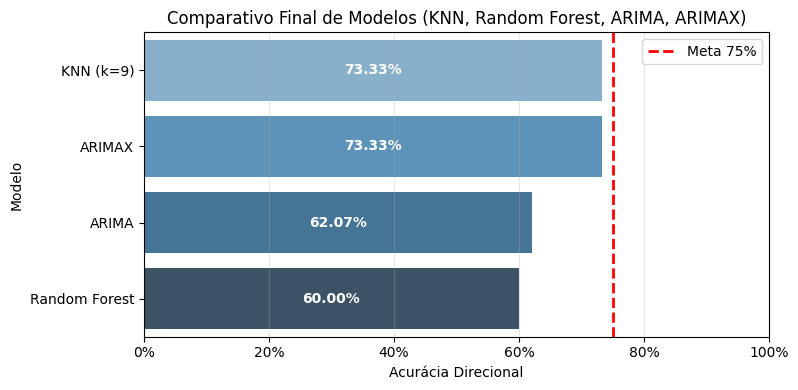

In [230]:
import matplotlib.ticker as mticker

plt.figure(figsize=(8, 4))
ax = sns.barplot(
    x='Acurácia Direcional',
    y='Modelo',
    data=resultados_modelos,
    palette='Blues_d')

for container in ax.containers:
    ax.bar_label(
        container,
        labels=[f'{v*100:.2f}%' for v in container.datavalues],
        label_type='center',
        fontsize=10,
        color='white',
        weight='bold')

# Linha de meta (75%)
meta = 0.75
plt.axvline(meta, color='red', linestyle='--', linewidth=2, label=f'Meta {meta*100:.0f}%')

# Ajustes visuais
plt.title('Comparativo Final de Modelos (KNN, Random Forest, ARIMA, ARIMAX)', fontsize=12)
plt.xlabel('Acurácia Direcional')
plt.ylabel('Modelo')
plt.xlim(0, 1)
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
ax.xaxis.set_major_formatter(mticker.PercentFormatter(1.0))
plt.show()